In [1]:
import pandas as pd
import numpy as np
import researchpy as rp
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
def draw_roc_curve(model, y_test, x_test):
    roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [6]:
dataset = pd.read_csv('bank-additional-full.csv', delimiter=';', na_values=['unknown', 'NaN']).dropna()

In [7]:
age_group = pd.DataFrame(dataset['age']).applymap(lambda x: round(x, -1) // 10)['age']
age_group_with_labels = pd.cut(dataset['age'], bins=[0, 20, 55, 100], labels=[1, 2, 3])
print(age_group.head())
print(age_group_with_labels.head())
dataset.insert(5, 'age_group', age_group)

0    6
2    4
3    4
4    6
6    6
Name: age, dtype: int64
0    3
2    2
3    2
4    3
6    3
Name: age, dtype: category
Categories (3, int64): [1 < 2 < 3]


In [8]:
dataset['housing'] = dataset['housing'].map({'yes': 1, 'no': 0})
dataset['default'] = dataset['default'].map({'yes': 1, 'no': 0})
dataset['loan'] = dataset['loan'].map({'yes': 1, 'no': 0})
dataset['y'] = dataset['y'].map({'no': 0, 'yes': 1})

In [9]:
dataset['job']= dataset['job'].map({
    'admin.': 1, 
    'blue-collar': 2, 
    'technician': 3, 
    'services': 4, 
    'management': 5, 
    'retired': 6, 
    'self-employed': 7, 
    'entrepreneur': 8, 
    'unemployed': 9,
    'housemaid': 10,
    'student': 11
}).astype({'job': 'category'})

dataset['education']= dataset['education'].map({
    'university.degree': 1, 
    'high.school': 2, 
    'professional.course': 3, 
    'basic.9y': 4, 
    'basic.4y': 5, 
    'basic.6y': 6, 
    'illiterate': 7
}).astype({'education': 'category'})

dataset['marital'] = dataset['marital'].map({
    'single': 1, 
    'married': 2, 
    'divorced': 3
}).astype({'marital': 'category'})

dataset['contact'] = dataset['contact'].map({
    'cellular': 1, 'telephone': 2
}).astype({'contact': 'category'})

dataset['month'] = dataset['month'].map({
    'jan': 1, 
    'feb': 2, 
    'mar': 3, 
    'apr': 4, 
    'may': 5, 
    'jun': 6, 
    'jul': 7, 
    'aug': 8, 
    'sep': 9, 
    'oct': 10, 
    'nov': 11, 
    'dec': 12}).astype({'month': 'category'})

dataset['poutcome'] = dataset['poutcome'].map({
    'failure': 1, 'nonexistent': 2, 'success': 3
}).astype({'poutcome': 'category'})

In [10]:
# dataset = pd.get_dummies(dataset, columns = ['job'])
# dataset = pd.get_dummies(dataset, columns = ['education'])
# dataset = pd.get_dummies(dataset, columns = ['marital'])
# dataset = pd.get_dummies(dataset, columns = ['age_group'])
# dataset = pd.get_dummies(dataset, columns = ['contact'])
# dataset = pd.get_dummies(dataset, columns = ['month'])
# dataset = pd.get_dummies(dataset, columns = ['poutcome'])

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30488 non-null  int64   
 1   job             30488 non-null  category
 2   marital         30488 non-null  category
 3   education       30488 non-null  category
 4   default         30488 non-null  int64   
 5   age_group       30488 non-null  int64   
 6   housing         30488 non-null  int64   
 7   loan            30488 non-null  int64   
 8   contact         30488 non-null  category
 9   month           30488 non-null  category
 10  day_of_week     30488 non-null  object  
 11  duration        30488 non-null  int64   
 12  campaign        30488 non-null  int64   
 13  pdays           30488 non-null  int64   
 14  previous        30488 non-null  int64   
 15  poutcome        30488 non-null  category
 16  emp.var.rate    30488 non-null  float64 
 17  cons.price.i

In [12]:
y = dataset['y']
x = dataset.drop(['age', 'marital', 'job', 'duration', 'contact', 'education', 'day_of_week', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'nr.employed', 'y'], axis=1)

In [13]:
x.head()

,default,age_group,housing,loan,month,campaign,poutcome,cons.conf.idx,euribor3m
0,0,6,0,0,5,1,2,-36.4,4.857
2,0,4,1,0,5,1,2,-36.4,4.857
3,0,4,0,0,5,1,2,-36.4,4.857
4,0,6,0,1,5,1,2,-36.4,4.857
6,0,6,0,0,5,1,2,-36.4,4.857


In [14]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=35, sampling_strategy=0.5)
sampled_x, sampled_y = under_sampler.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(sampled_x, sampled_y, test_size=0.3, random_state=35)

# we can Check the numbers of our data
num_no = sampled_y.value_counts()[0]
num_yes = sampled_y.value_counts()[1]
num_yes_pct = num_yes/(num_no + num_yes)
num_no_pct = 1 - num_yes_pct
print(f'number of no in undersampled data: {num_no}')
print(f'number of yes in undersampled data: {num_yes}')
print(f'number of yes in percentage: {num_yes_pct}')
print(f'number of yes in percentage: {num_no_pct}')

number of no in undersampled data: 7718
number of yes in undersampled data: 3859
number of yes in percentage: 0.3333333333333333
number of yes in percentage: 0.6666666666666667


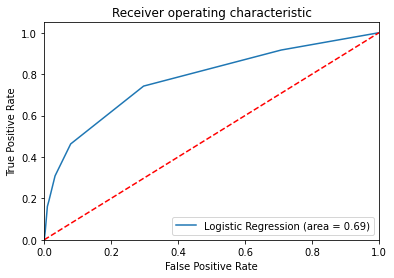

In [15]:
from sklearn.tree import DecisionTreeClassifier

treeClassifier = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=35)
treeClassifier.fit(X_train, y_train)
draw_roc_curve(treeClassifier, y_test, X_test)

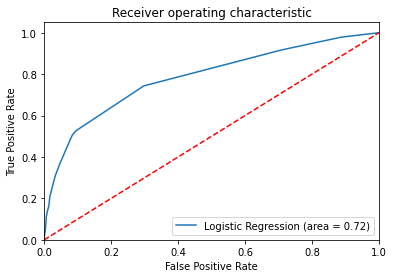

In [19]:
treeClassifier = DecisionTreeClassifier(criterion="entropy", random_state=35)
scores = []

# looking for the best max depth
for i in range(1, 6):
    treeClassifier.max_depth = i
    treeClassifier.fit(X_train, y_train)
    y_pred = treeClassifier.predict(X_test)
    scores.append(recall_score(y_pred, y_test))

best_score = np.max(scores)
best_depth = scores.index(best_score)
treeClassifier = DecisionTreeClassifier(criterion="entropy", random_state=35, max_depth=best_depth)
treeClassifier.fit(X_train, y_train)
draw_roc_curve(treeClassifier, y_test, X_test)

In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_reg.score(X_train,y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.77      0.91      0.84      2314
           1       0.73      0.47      0.57      1160

    accuracy                           0.76      3474
   macro avg       0.75      0.69      0.70      3474
weighted avg       0.76      0.76      0.75      3474



In [21]:
result = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='precision')
result.mean()

0.7253205763431331

In [22]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True negative: {tn}')
print(f'True positive: {tp}')
print(f'False negative: {fn}')
print(f'False positive: {fp}')

True negative: 2111
True positive: 540
False negative: 620
False positive: 203


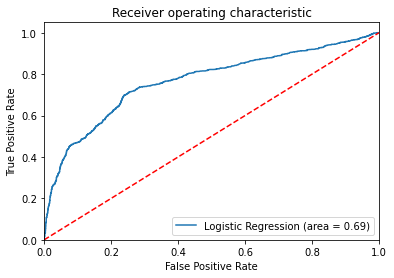

In [23]:
draw_roc_curve(log_reg, y_test, X_test)